参考：
https://tf.wiki/zh_hans/basic/models.html#zh-hans-sequential-functional

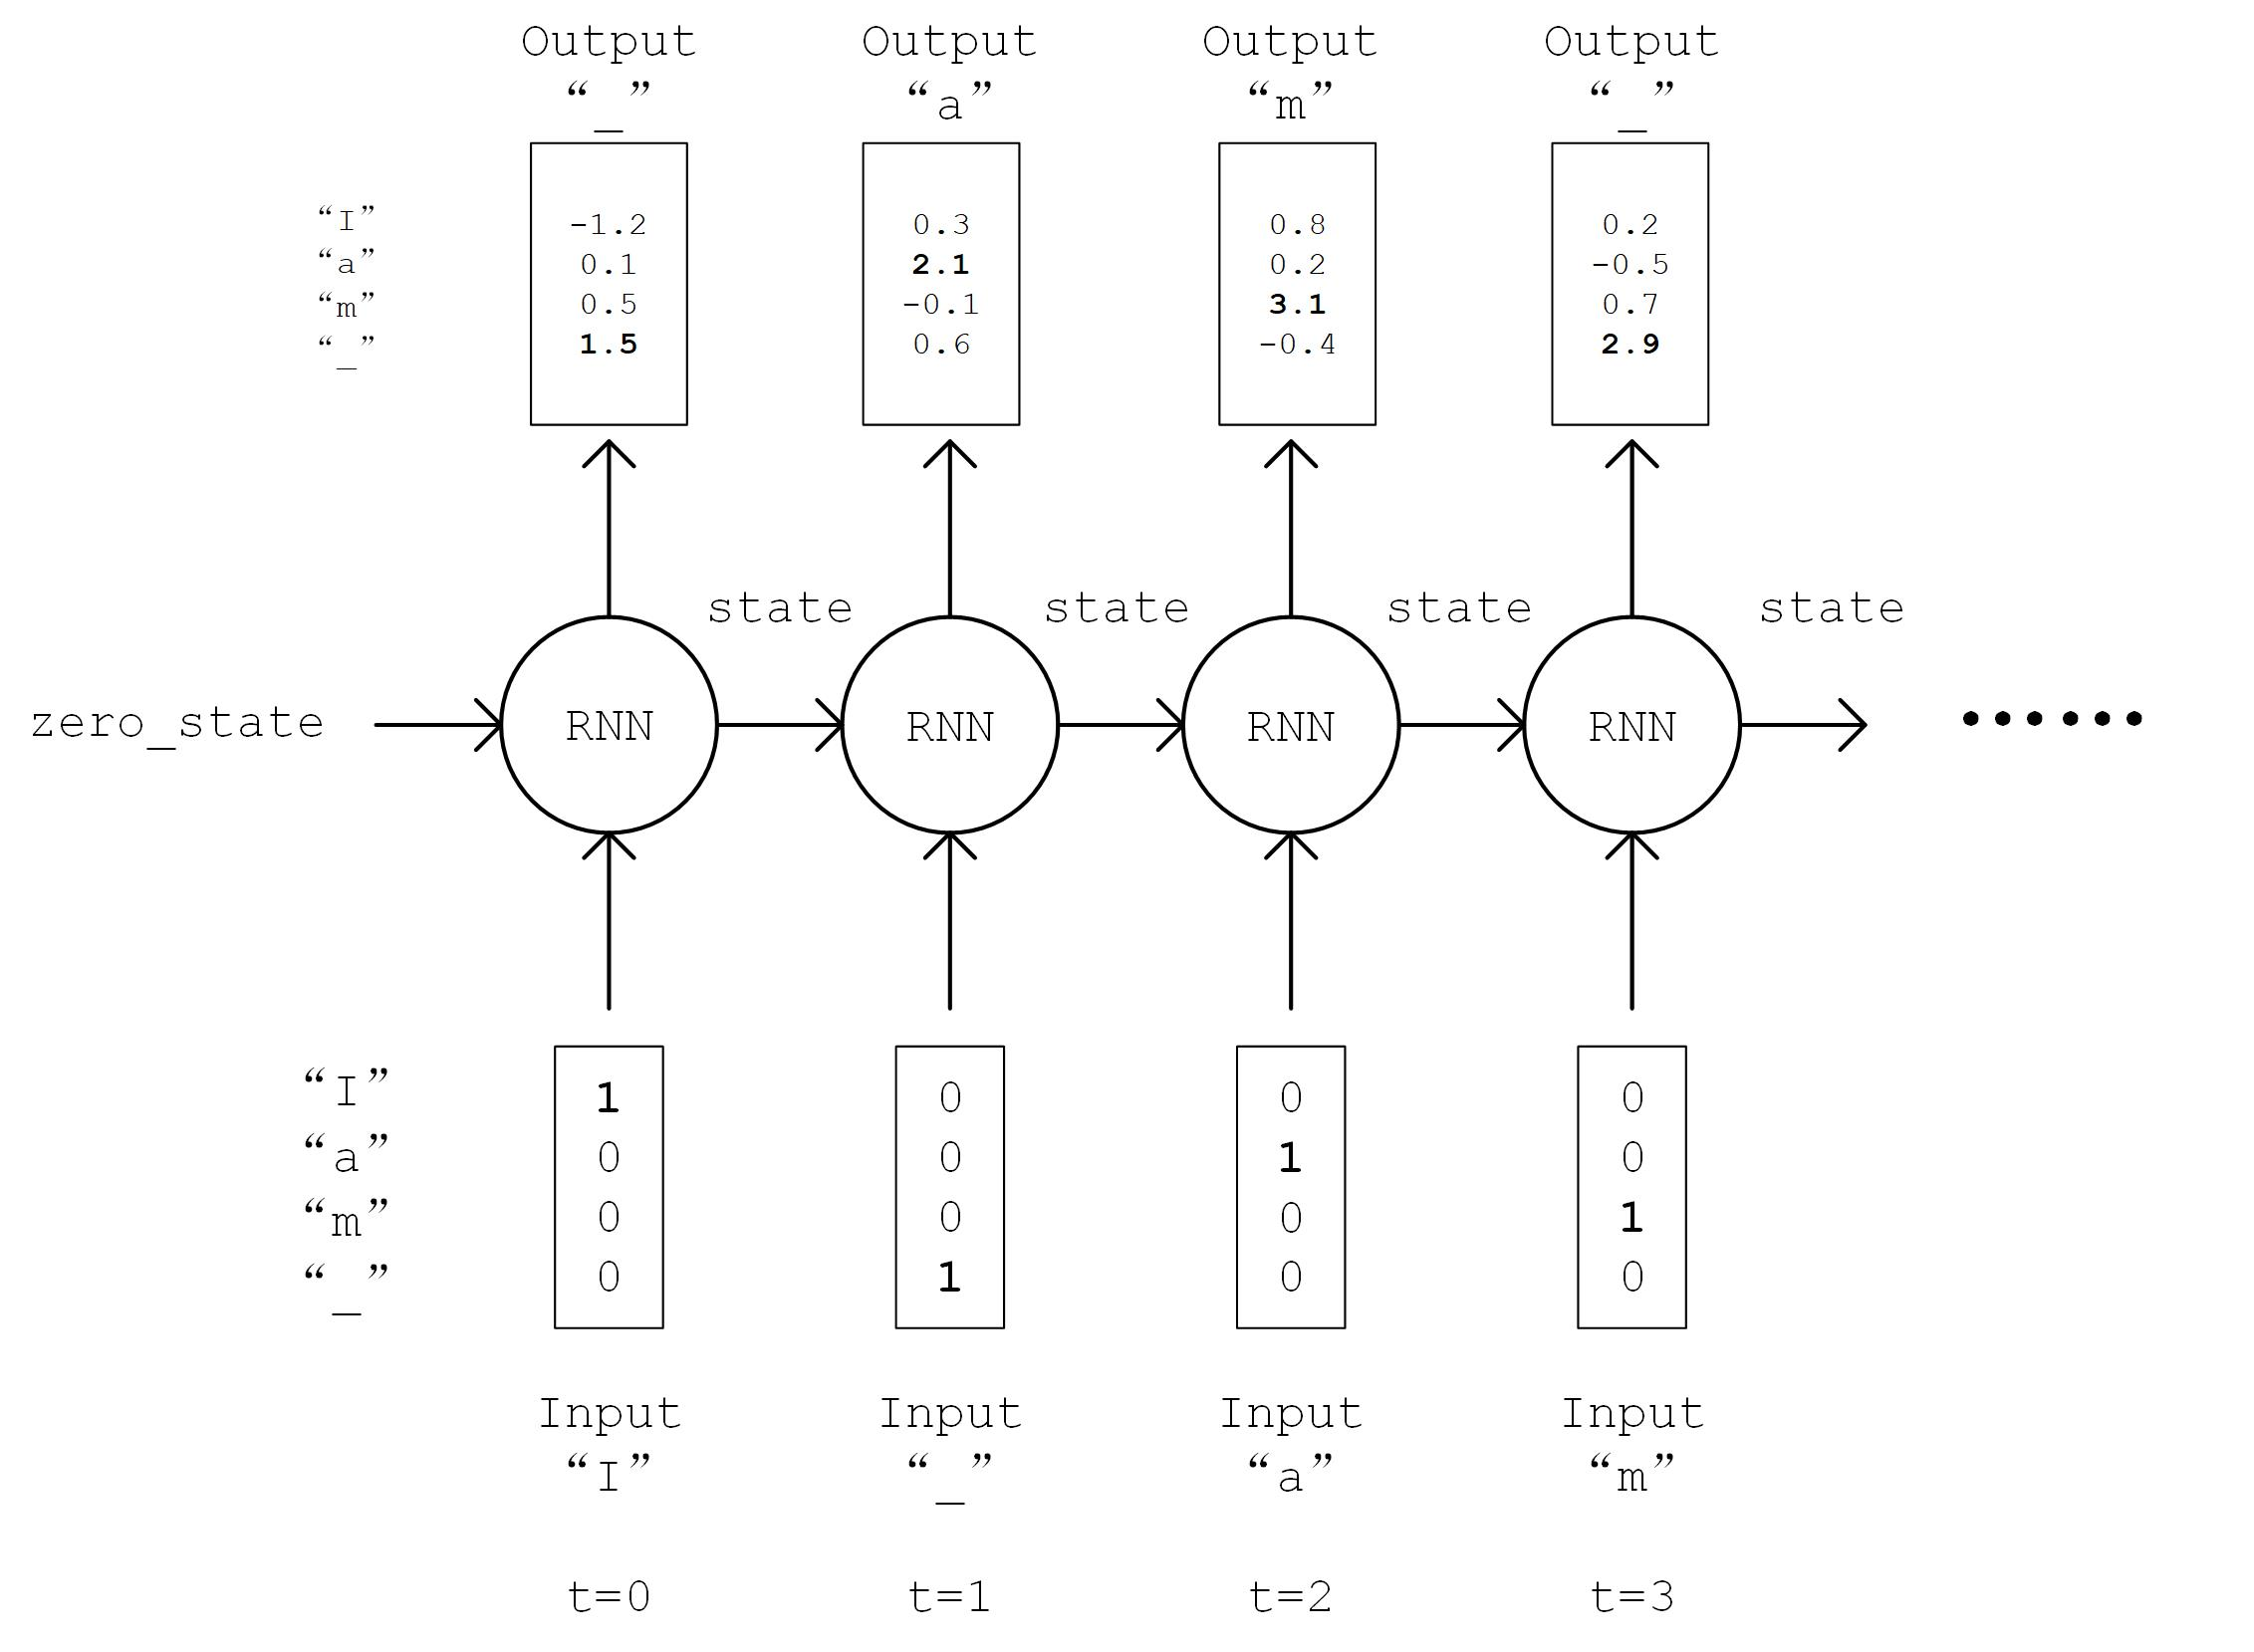

In [6]:
import tensorflow as tf
import numpy as np

class DataLoader():
    def __init__(self):
        path = tf.keras.utils.get_file('nietzsche.txt',
            origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
        with open(path, encoding='utf-8') as f:
            self.raw_text = f.read().lower()
        self.chars = sorted(list(set(self.raw_text)))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
        self.text = [self.char_indices[c] for c in self.raw_text]

    def get_batch(self, seq_length, batch_size):
        seq = []
        next_char = []
        for i in range(batch_size):
            index = np.random.randint(0, len(self.text) - seq_length)
            seq.append(self.text[index:index+seq_length])
            next_char.append(self.text[index+seq_length])
        return np.array(seq), np.array(next_char)       # [batch_size, seq_length], [num_batch]

In [10]:
class RNN(tf.keras.Model):
    def __init__(self, num_chars, batch_size, seq_length):
        super().__init__()
        self.num_chars = num_chars
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.cell = tf.keras.layers.LSTMCell(units=256)
        self.dense = tf.keras.layers.Dense(units=self.num_chars)

    def call(self, inputs, from_logits=False):
        inputs = tf.one_hot(inputs, depth=self.num_chars)       # [batch_size, seq_length, num_chars]
        state = self.cell.get_initial_state(batch_size=self.batch_size, dtype=tf.float32)   # 获得 RNN 的初始状态
        for t in range(self.seq_length):
            output, state = self.cell(inputs[:, t, :], state)   # 通过当前输入和前一时刻的状态，得到输出和当前时刻的状态
        logits = self.dense(output)
        if from_logits:                     # from_logits 参数控制输出是否通过 softmax 函数进行归一化
            return logits
        else:
            return tf.nn.softmax(logits)
    def predict(self, inputs, temperature=1.):
        batch_size, _ = tf.shape(inputs)
        logits = self(inputs, from_logits=True)                         # 调用训练好的RNN模型，预测下一个字符的概率分布
        prob = tf.nn.softmax(logits / temperature).numpy()              # 使用带 temperature 参数的 softmax 函数获得归一化的概率分布值
        return np.array([np.random.choice(self.num_chars, p=prob[i, :]) # 使用 np.random.choice 函数，
                         for i in range(batch_size.numpy())])           # 在预测的概率分布 prob 上进行随机取样

In [19]:
num_batches = 400  # 1000
seq_length = 40
batch_size = 50
learning_rate = 3e-2

data_loader = DataLoader()
model = RNN(num_chars=len(data_loader.chars), batch_size=batch_size, seq_length=seq_length)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
for batch_index in range(num_batches):
    X, y = data_loader.get_batch(seq_length, batch_size)
    with tf.GradientTape() as tape:
        y_pred = model(X)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)
        loss = tf.reduce_mean(loss)
        print("batch %d: loss %f" % (batch_index, loss.numpy()))
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
    


batch 0: loss 4.033834
batch 1: loss 4.317031
batch 2: loss 4.055045
batch 3: loss 4.440088
batch 4: loss 5.004027
batch 5: loss 4.084168
batch 6: loss 3.688285
batch 7: loss 3.492290
batch 8: loss 3.571707
batch 9: loss 3.289902
batch 10: loss 3.513448
batch 11: loss 3.366548
batch 12: loss 3.579629
batch 13: loss 3.409810
batch 14: loss 3.019387
batch 15: loss 3.164067
batch 16: loss 2.946639
batch 17: loss 3.139404
batch 18: loss 3.402772
batch 19: loss 2.922621
batch 20: loss 3.053023
batch 21: loss 3.163200
batch 22: loss 3.239222
batch 23: loss 3.305204
batch 24: loss 2.883048
batch 25: loss 3.010277
batch 26: loss 3.218721
batch 27: loss 3.180643
batch 28: loss 3.347117
batch 29: loss 3.383718
batch 30: loss 3.140561
batch 31: loss 3.132457
batch 32: loss 3.179719
batch 33: loss 3.380884
batch 34: loss 3.026429
batch 35: loss 3.135559
batch 36: loss 2.755404
batch 37: loss 3.494383
batch 38: loss 3.244629
batch 39: loss 3.494178
batch 40: loss 3.345531
batch 41: loss 3.240613
ba

batch 334: loss 2.301219
batch 335: loss 2.668375
batch 336: loss 2.299356
batch 337: loss 2.518536
batch 338: loss 2.726315
batch 339: loss 2.661911
batch 340: loss 2.253156
batch 341: loss 2.439424
batch 342: loss 2.461680
batch 343: loss 2.548553
batch 344: loss 2.507436
batch 345: loss 2.582651
batch 346: loss 2.472774
batch 347: loss 2.377286
batch 348: loss 2.671773
batch 349: loss 2.595380
batch 350: loss 2.565473
batch 351: loss 2.669191
batch 352: loss 2.487736
batch 353: loss 2.280399
batch 354: loss 2.588581
batch 355: loss 2.669535
batch 356: loss 2.464122
batch 357: loss 2.542096
batch 358: loss 2.625961
batch 359: loss 2.031019
batch 360: loss 2.474168
batch 361: loss 2.543068
batch 362: loss 2.564079
batch 363: loss 2.314454
batch 364: loss 2.329576
batch 365: loss 2.355580
batch 366: loss 2.805145
batch 367: loss 2.502275
batch 368: loss 2.158342
batch 369: loss 2.357369
batch 370: loss 2.383783
batch 371: loss 2.288848
batch 372: loss 2.877092
batch 373: loss 2.189621


In [20]:
X_, _ = data_loader.get_batch(seq_length, 1)
for diversity in [0.2, 0.5, 1.0, 1.2]:      # 丰富度（即temperature）分别设置为从小到大的 4 个值
    X = X_
    print("diversity %f:" % diversity)
    for t in range(400):
        y_pred = model.predict(X, diversity)    # 预测下一个字符的编号
        print(data_loader.indices_char[y_pred[0]], end='', flush=True)  # 输出预测的字符
        X = np.concatenate([X[:, 1:], np.expand_dims(y_pred, axis=1)], axis=-1)     # 将预测的字符接在输入 X 的末尾，并截断 X 的第一个字符，以保证 X 的长度不变
    print("\n")

diversity 0.200000:
 in the her in in the he he he he sers in the he sere ser an the he se ser in the he the he serer in the in the in in the he he he he he he her in in the he he ser in the he ser in the he sis in the in the he ser in the he ser in the hin in the he he ser in in the in in the he her in the ser in the her in the he he ser in the he ser in the her in the he he se ne he he s in the her an the he he he 

diversity 0.500000:
s an sthe ingher an fa elisere the s cal the den in ne he hen, in in the her in it intic is ios in ther in se se hen in in the erens ig rers atre of in in se whe he mel is in in the ser ens ren in is the se he hin ghe exs in se ser in tho hon in is he por the s an in as ire he sor and then enche s in an the ser an in lerery re he isecen in the nes of in the bence mes in the ind beg it  al or an in

diversity 1.000000:
gelss the rercitkinghe fos har)e thltsthe ere s therttinlieg! ghe wh thisn tit im
the s wll thiery "xans is
h  otly,"ees, pot igan . hor